# Problem 1

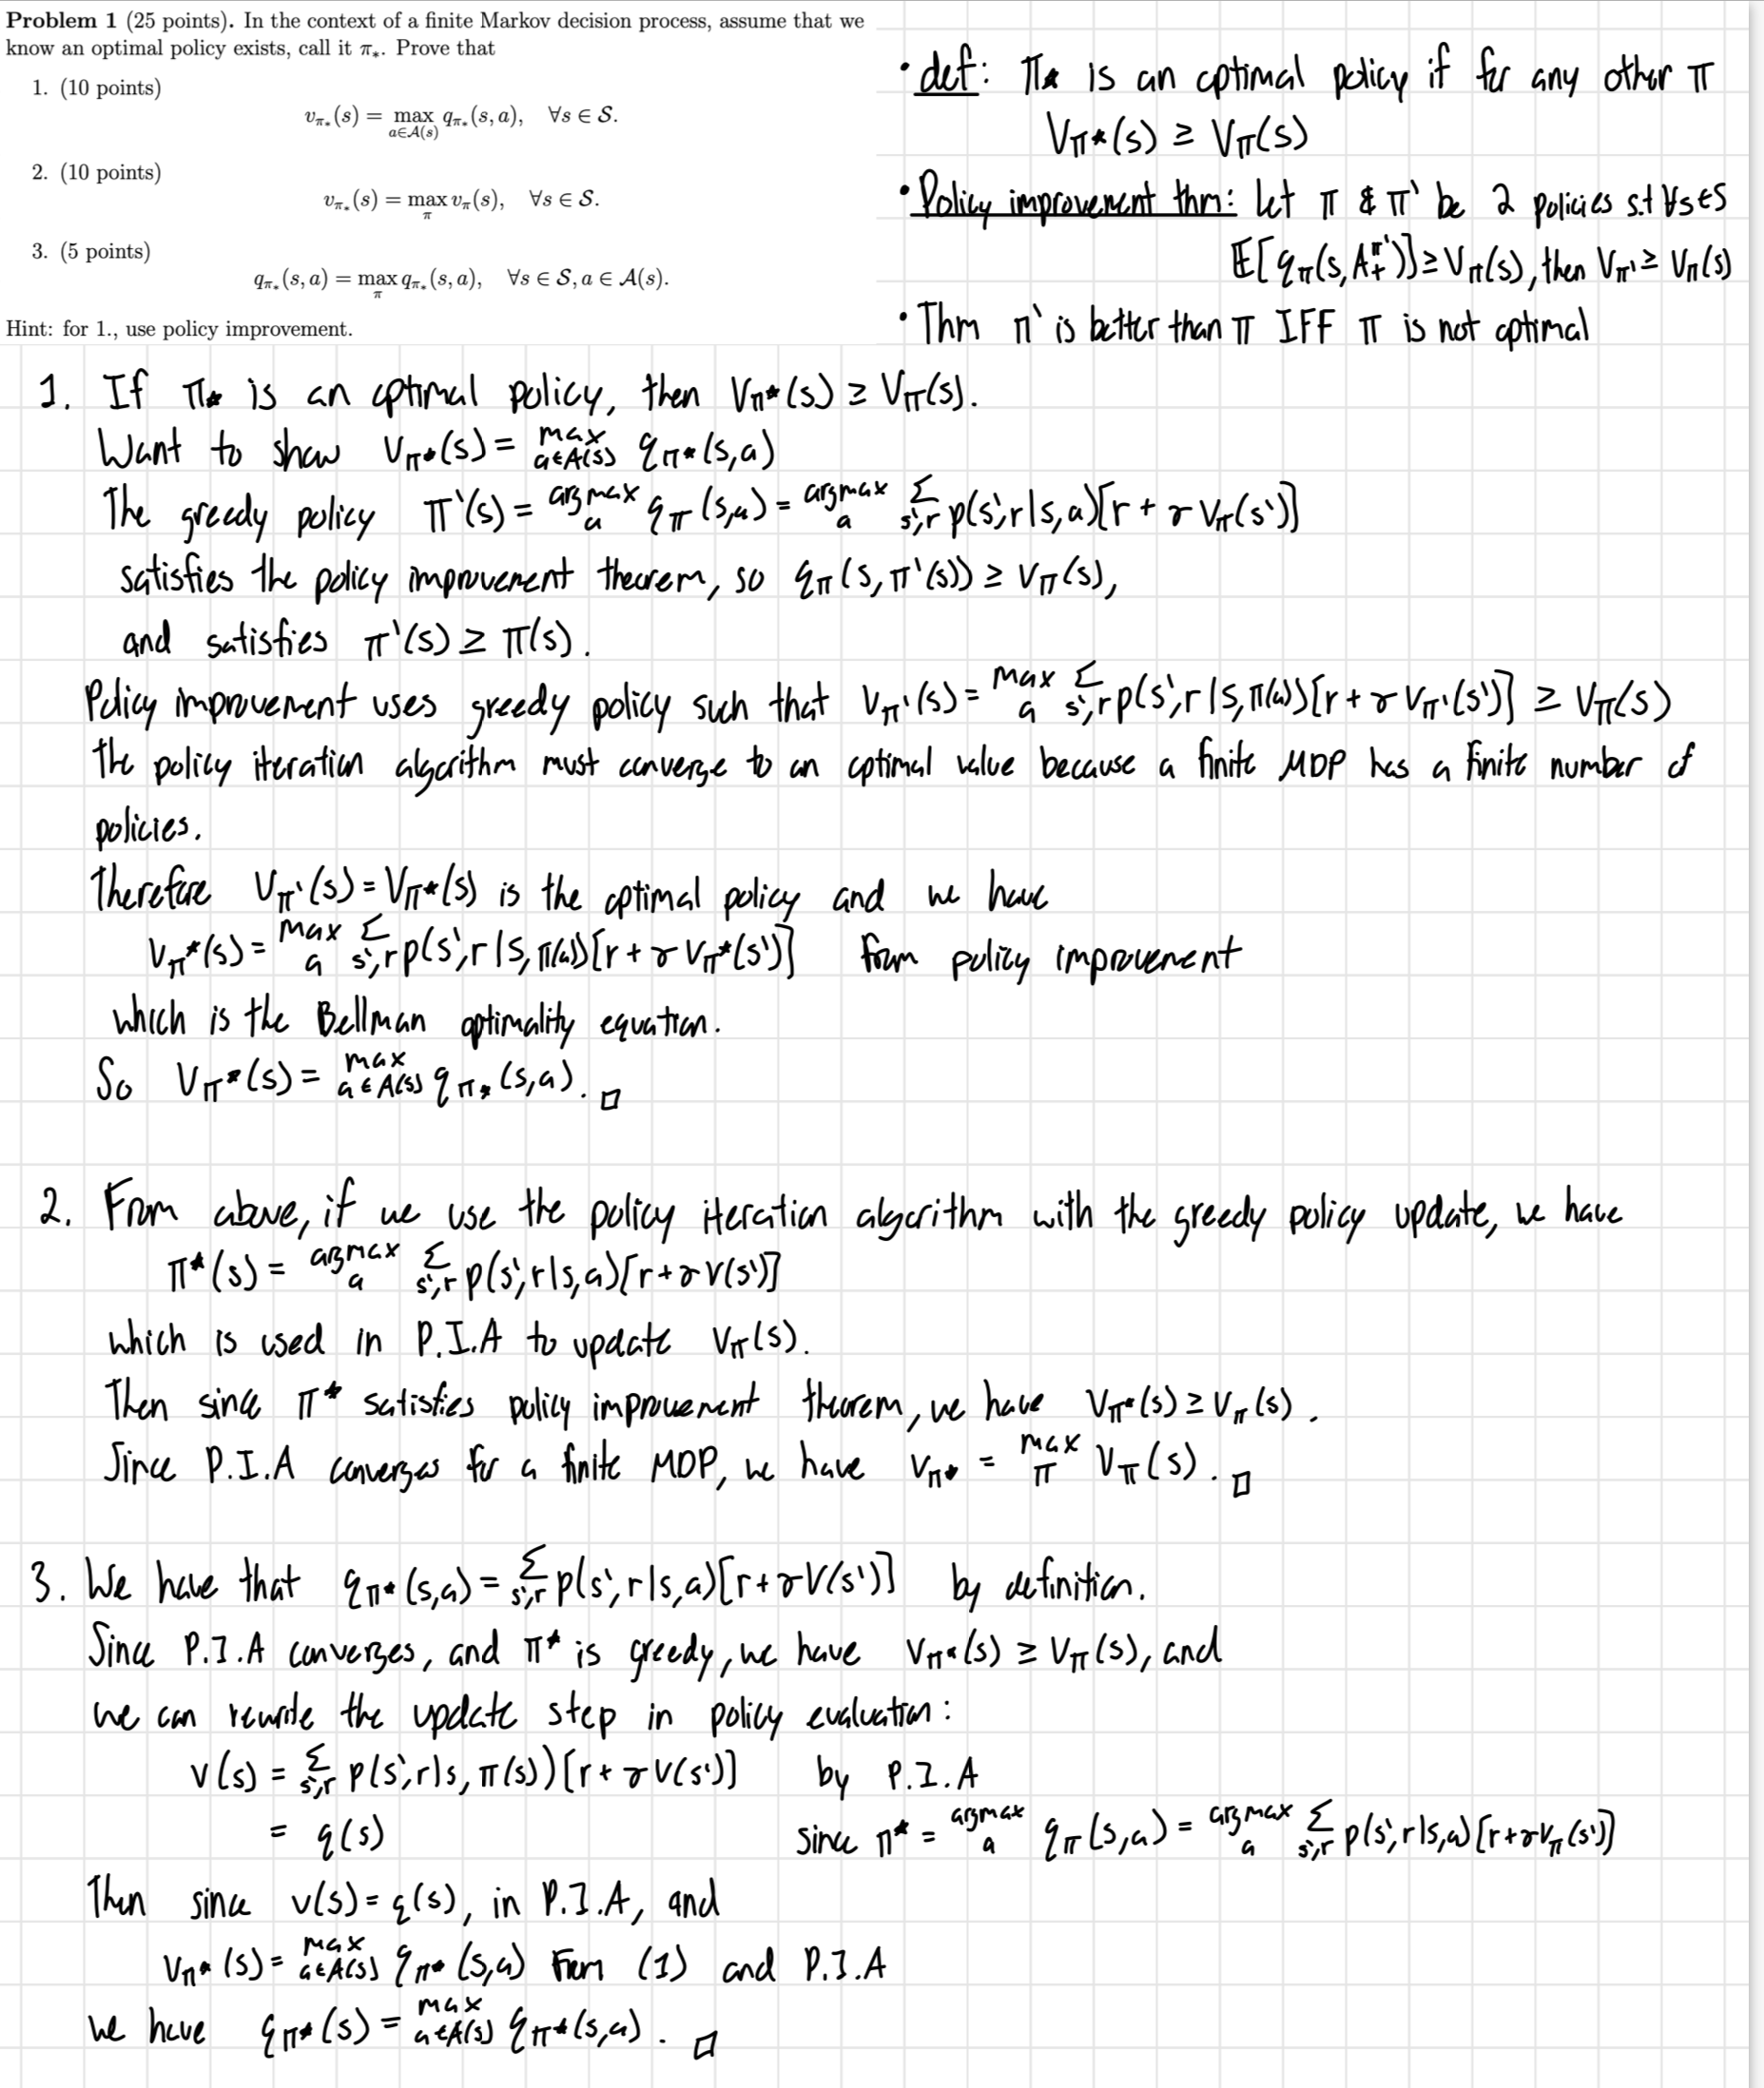

# Probelm 2

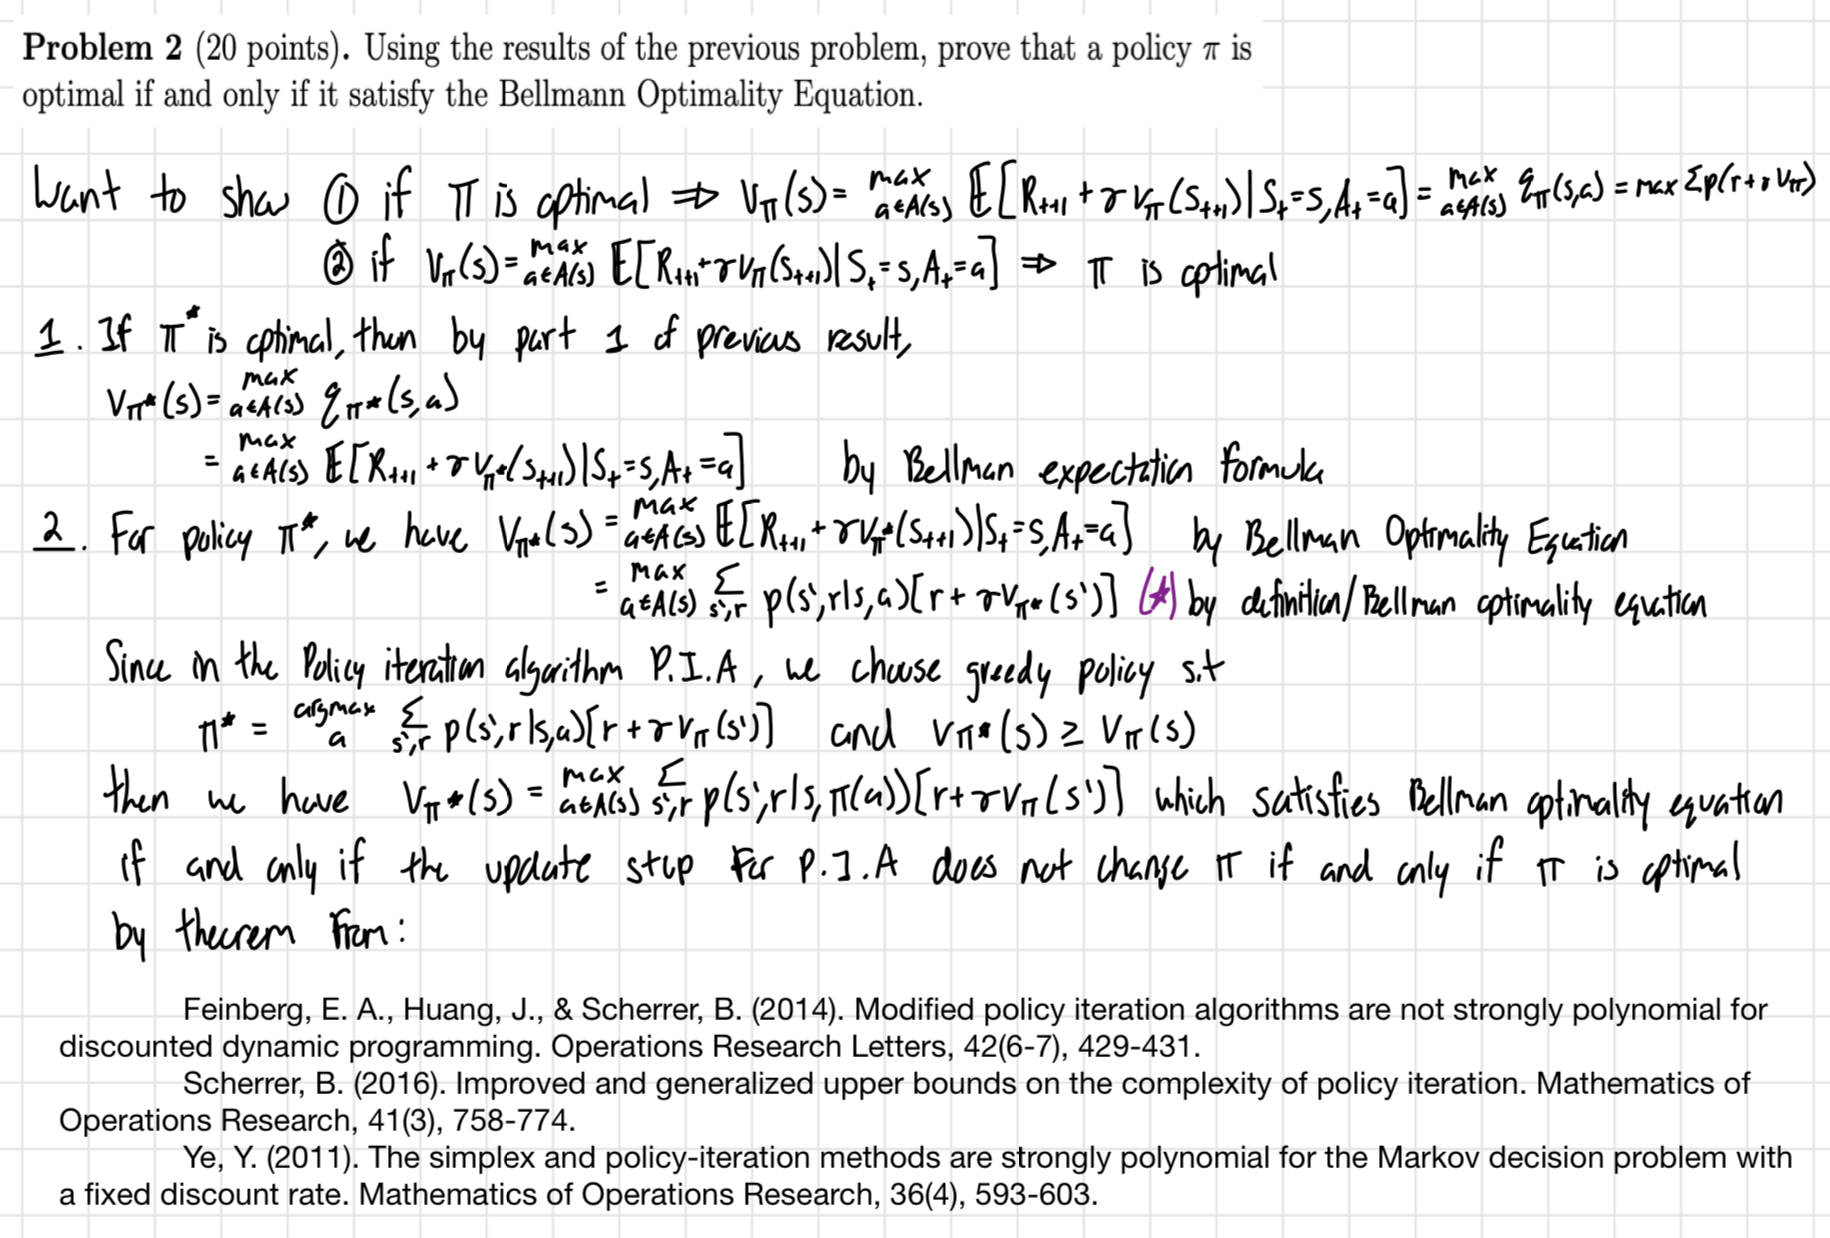

# Problem 3

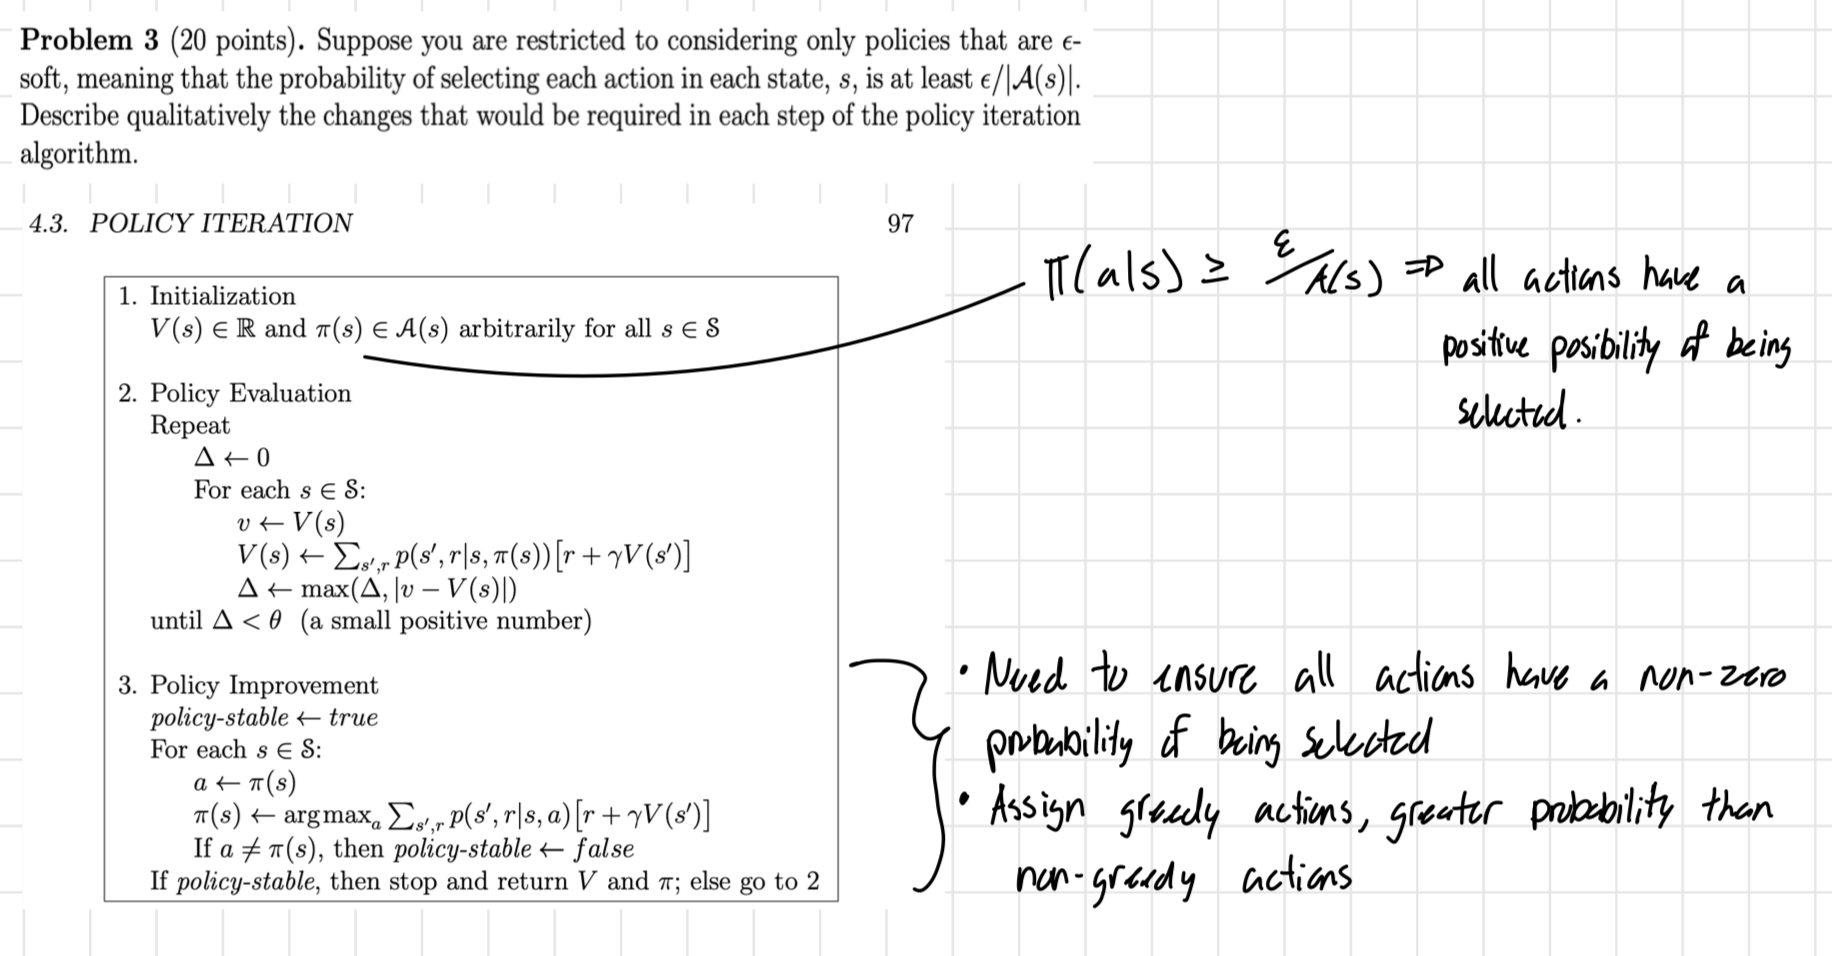

# Problem 4

### Introduction
In this notebook we will implement value iteration and use it to solve the gambler's problem. This is based on the book by Sutton-Barto, specifically this version: https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf

### Choosing a $\gamma$
Recall that $\gamma \in [0, 1]$ is the discount factor used to compute the expected discounted returns
$$G_t = \sum_{k = 0}^\infty \gamma^k R_{t + k + 1}.$$
This hyperparameter $\gamma$ controls how farsighted the agent is, and it also ensures that $G_t$ is finite in the case of infinitely many bounded nonzero terms. (See Sections 3.3, 3.4 in Sutton-Barto.) Choose $\gamma$ for the present case of a finite MDP.

In [1]:
# TODO: define `GAMMA`
GAMMA = 0.9

### General objects
Here is a general class template that represents a finite Markov decision process (MDP).

In [2]:
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import numpy as np

class MDP:

    @property
    def states(self):
        '''
        Returns:
            (set) The states of this MDP.
        '''
        pass

    def actions(self, state):
        '''
        Returns:
            (set) The actions allowed from `state`.
        '''
        pass

    def psr(self, state, action):
        '''
        Returns:
            (set) The set of tuples (p, s, r) where `s` is a state reachable
                from `state` by performing `action`, `p` is the probability
                of reaching `s`, and `r` is the reward gained by reaching `s`.
                In particular, the sum of the `p` equals 1.
        '''
        pass

### Implementing the gambler's problem
To make our implementation compatible with value iteration, we will include the state `self.goal`. Recall that the reward of reaching the goal is $1$ and that the reward of reaching any other state is $0.$ Moreover, recall that the MDP ends once either `0` or `self.goal` is reached. How should the state `self.goal` behave, e.g. what should the available actions and rewards from this state be? With this in mind, fix the below naive implementation of the gambler's problem. You can use the rest of the notebook (in particular the last cell) to test your implementation.

In [3]:
class GamblersProblem(MDP):
    '''
    The gambler's problem, as described in Example 4.3 of Sutton-Barto.
    '''
    
    def __init__(self, p_h, goal):
        assert 0 <= p_h <= 1
        self.p_h = p_h
        self.goal = goal

    @property
    def states(self): # TODO: fix this
        # states = {1,...99)
        # terminal state = {0,self.goal}
        return set(range(0,self.goal+1))

    def actions(self, state): # TODO: fix this
        # actions = {0, 1, . . . , min(s, 100 − s)}
        return set(range(min(state, self.goal - state)+1))

    def psr(self, state, action): # TODO: fix this
        # returns (probability, state, action)
        return {
            (
                self.p_h, # heads, i.e. the gambler wins money
                state + action,
                1 if state + action == self.goal else 0
            ), (
                1 - self.p_h, # tails, i.e. the gambler loses money
                max(state - action,0), # state is not less than zero
                0
            ) 
        }

    def plot_policy(self, policy):
        for s, actions in policy.items():
            xy = [(s, action) for action in actions]
            plt.scatter(
                *zip(*xy),
                # purple if there are multiple actions
                color='purple' if len(actions) > 1 else 'blue', 
                marker='.'
            )

    def plot_value(self, value):
        xy = [(s, v) for s, v in value.items()]
        plt.plot(*zip(*xy))

### Value functions

Here is a general class that represents a value function on a finite MDP. Implement the `truncated_evaluations` and `greedy_policy` methods, replacing the currently obfuscated code, recalling that the truncated evaluation (see Section 4.4 in Sutton-Barto) for a value function $v,$ a state $s,$ and an action $a$ is
$$\mathbb{E}[R_{t + 1} + \gamma v(S_{t + 1}) \mid S_t = s, A_t = a] = \sum_{(s', r)} p(s', r \mid s, a)[r + \gamma v(s')].$$

In [7]:
class Value(dict):

    def truncated_evaluations(self, mdp): # TODO: implement this
        '''
        Returns:
            (dict) The truncated policy evaluations for every state and
                every action. The keys are the states, and the values are
                dicts keyed by actions with value the truncated policy
                evaluation of performing the action at the state.
        '''
        # the following code works (so that the rest of the notebook works)
        # but is obfuscated
        # trunc_evals = {}
        # for a in mdp.states: #
        #     state_evals = {}
        #     for actions in mdp.actions(a):#
        #         e_return = 0
        #         e_return = sum(s_prime * (s + GAMMA * self[p]) for s_prime, p, s in mdp.psr(a, actions))
        #         state_evals[actions] = e_return
        #     trunc_evals[a] = state_evals
        trunc_evals = {state: {actions: sum(s_prime * (s + GAMMA * self[p]) for s_prime, p, s in mdp.psr(state, actions))
                               for actions in mdp.actions(state)}
                       for state in mdp.states}
        return trunc_evals

    def greedy_policy(self, mdp, tiebreak='equal_split'):
        '''
        The greedy policy (with respect to the truncated policy evaluations).

        Args:
            tiebreaker: Decides what to do in case there are multiply actions
                with the same truncated policy evaluation. The options are
                'equal_split' (of the probabilities), 'max' (of the actions),
                'min' (of the actions), 'random' (action).
        '''
        greedy_actions = {
            s: {a for a, v in evals.items() if v == max(evals.values())}
            for s, evals in self.truncated_evaluations(mdp).items()
        }
        tiebreaker = lambda actions: {
            'equal_split': {a: 1 / len(actions) for a in actions},
            'max': {max(actions): 1.0},
            'min': {min(actions): 1.0},
            'random': {random.choice(list(actions)): 1.0},
        }[tiebreak]
        return {
            s: tiebreaker(actions)
            for s, actions in greedy_actions.items()
        }

### Value iteration algorithm
The pseudocode for value iteration in Sutton-Barto (see Figure 4.5 in Sutton-Barto on page 101) has a slight error. Namely, it is using asynchronous dynamic programming (see the following Section 4.5 in Sutton-Barto) because it updates $V(s)$ in place, i.e. it is using the updated value of $V(s)$ for the subsequent computations of $V(s')$ for other $s'.$ The pseudocode is also non-Pythonic. Below is an implementation following their pseudocode, which we will use during section. Reimplement this so that it is the intended algorithm and in a Pythonic way.

In [124]:
def value_iteration_algorithm(mdp, theta=1e-15, max_iter=200, tiebreak='equal_split'):
    '''
    The value iteration algorithm (but not really, because see above) following
    the pseudocode in Sutton-Barto.
    '''
    V = Value({state: 0 for state in mdp.states}) # create a Value object
    pbar = tqdm(range(max_iter))
    # truncated evaluation for every state
    trunc_evals = {state: np.array(list(V.truncated_evaluations(mdp)[state].values())) for state in mdp.states} 
    
    for iter in pbar:
        Delta = 0
        V_new = Value(V) 
        for s in mdp.states:
            v = V[s]
            V_new[s] = np.max(trunc_evals[s]) # update V_new
            Delta = max(Delta, abs(v - V_new[s]))
        # update V with values of V_new
        # do not update terminal states (first and last values of mdp.states)
        V.update({s: V_new[s] for s in mdp.states - {0, mdp.goal}})
        
        if Delta < theta:
            break
        V[mdp.goal] = 1
        mdp.plot_value(V)
        pbar.set_description(f'delta={Delta:<6.3}  V[50]={V[50]:<6}  V[100]={V[100]:<6}')  
    plt.show()
    return V.greedy_policy(mdp, tiebreak=tiebreak)

In [125]:
def value_iteration_algorithm1(mdp, theta=1e-15, max_iter=200, tiebreak='equal_split'):
    '''
    The value iteration algorithm (but not really, because see above) following
    the pseudocode in Sutton-Barto.
    '''
    V = Value({state: 0 for state in mdp.states})
    pbar = tqdm(range(max_iter))
    
    for iter in pbar:
        Delta = 0
        # update V with values of V_new
        # do not update terminal states (first and last values of mdp.states)
        for s in mdp.states - {0, mdp.goal}:
            v = V[s]
            V[s] = max(V.truncated_evaluations(mdp)[s].values())
            Delta = max(Delta, abs(v - V[s]))
        if Delta < theta:
            break
        V[mdp.goal] = 1
        mdp.plot_value(V)
        pbar.set_description(f'{Delta=}  {V[50]=:<6}  {V[100]=:<6}')
    plt.show()
    
    return V.greedy_policy(mdp, tiebreak=tiebreak)

In [111]:
def value_iteration_algorithm2(mdp, theta=1e-15, max_iter=200, tiebreak='equal_split'):
    '''
    The value iteration algorithm (but not really, because see above) following
    the pseudocode in Sutton-Barto.
    '''
    # TODO: Reimplement this.
    
    V = Value({state: 0 for state in mdp.states})
    pbar = tqdm(range(max_iter))
    for iter in pbar:
        Delta = 0
        for s in mdp.states:
            v = V[s]
            V[s] = max(V.truncated_evaluations(mdp)[s].values())
            Delta = max(Delta, abs(v - V[s]))
        if Delta < theta:
            break
            
        mdp.plot_value(V)
        pbar.set_description(f'{Delta=:<6.3}  {V[50]=:<6.3}  {V[100]=:<6.3}')
    plt.show()
    
    return V.greedy_policy(mdp, tiebreak=tiebreak)

### Playing around with the gambler's problem
Use the cell below to test various values of $p_h.$

delta=0.45    V[50]=0.55    V[100]=1     : 100%|██████████| 200/200 [00:00<00:00, 462.33it/s]


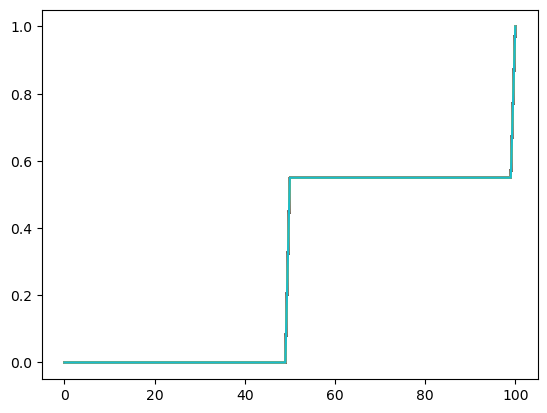

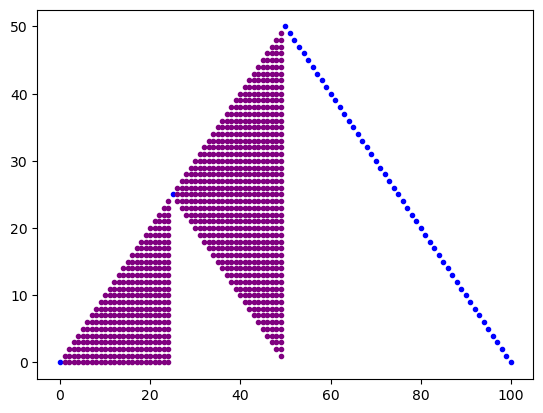

In [130]:
mdp = GamblersProblem(0.55, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

delta=0.75    V[50]=0.25    V[100]=1     : 100%|██████████| 200/200 [00:00<00:00, 426.14it/s]


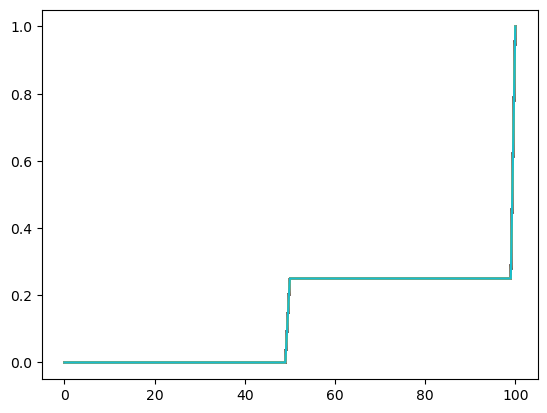

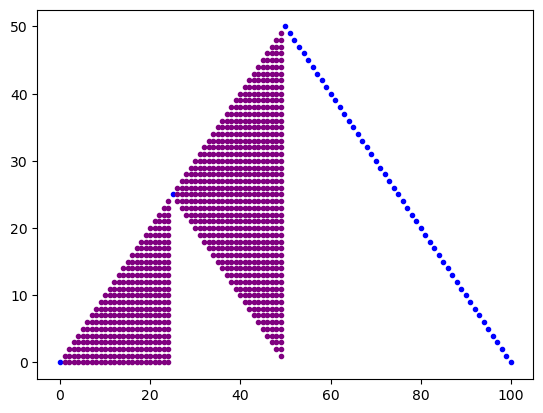

In [131]:
mdp = GamblersProblem(0.25, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

Delta=1.3322676295501878e-15  V[50]=1.045   V[100]=1     :  22%|██▏       | 43/200 [00:09<00:33,  4.62it/s]


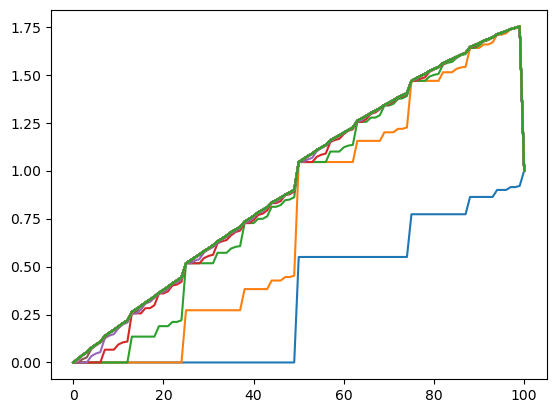

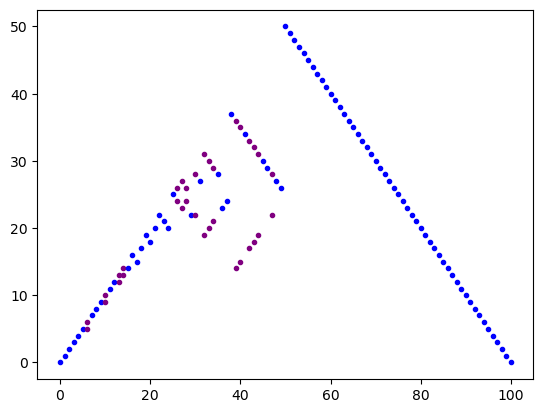

In [132]:
mdp = GamblersProblem(0.55, 100)
mdp.plot_policy(value_iteration_algorithm1(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

Delta=2.4631447055611932e-15  V[50]=0.475   V[100]=1     :  10%|█         | 21/200 [00:04<00:39,  4.55it/s]


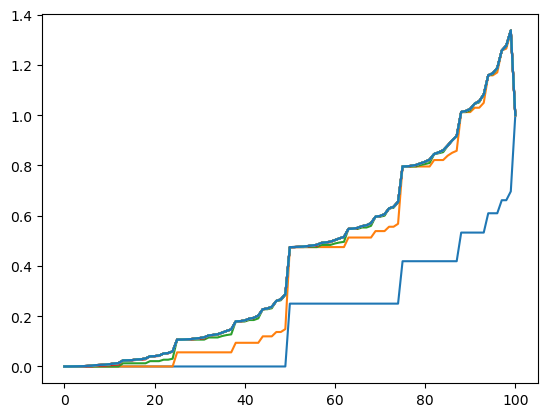

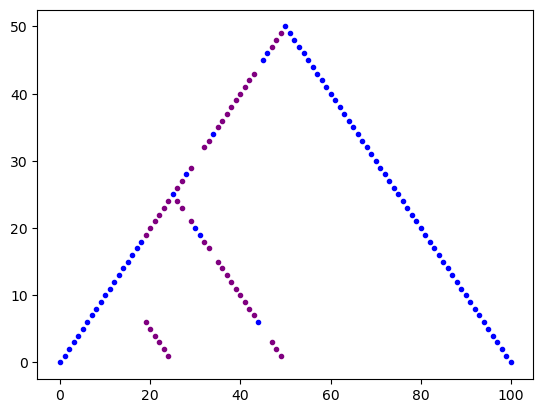

In [133]:
mdp = GamblersProblem(0.25, 100)
mdp.plot_policy(value_iteration_algorithm1(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

# Problem 5

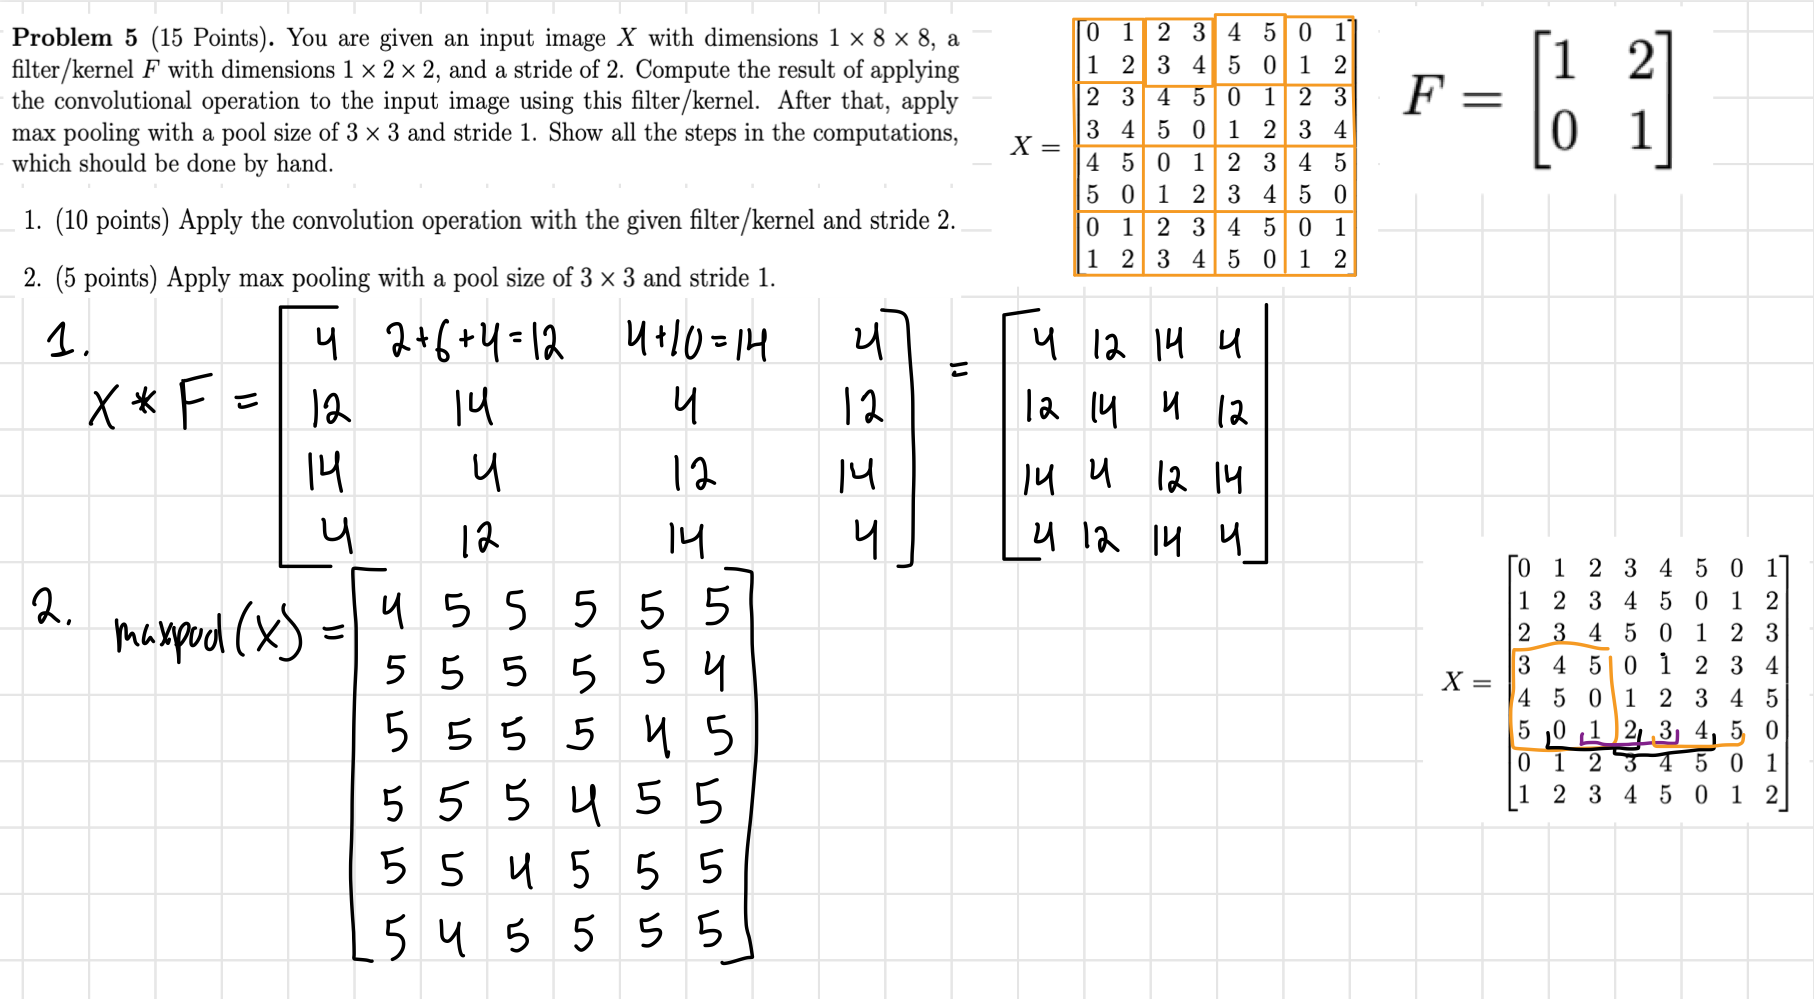